# Fraud detection

Fraudulent activities, whether initiated through phone calls, emails, or face-to-face interactions, pose a significant threat to individuals on a daily basis. Recognizing the warning signs of scams is crucial in safeguarding against financial losses. In this project, I aim to develop a predictive model to ascertain whether a fraud incident made a victim or was it just an attempt.. I am using a dataset from the Canadian Anti-Fraud Centre, specifically the [Fraud Reporting System database](https://open.canada.ca/data/en/dataset/6a09c998-cddb-4a22-beff-4dca67ab892f), which gathers reports from different places, including online submissions by people. The data spans from 2021 to 2023. All the files for this project are available for [download](https://github.com/DorisKJ/Fraud_Detection). 

Disclaimer: This exercise is learning purposes.

## 1. Exploratory data analysis
### Overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('cafc-open-gouv-database-2021-01-01-to-2023-12-31-extracted-2024-01-02.csv')
data.head(3)

,Numéro d'identification / Number ID,Date Received / Date reçue,Complaint Received Type,Type de plainte reçue,Country,Pays,Province/State,Province/État,Fraud and Cybercrime Thematic Categories,Catégories thématiques sur la fraude et la cybercriminalité,...,Méthode de sollicitation,Gender,Genre,Language of Correspondence,Langue de correspondance,Victim Age Range / Tranche d'âge des victimes,Complaint Type,Type de plainte,Number of Victims / Nombre de victimes,Dollar Loss /pertes financières
0,1,2021-01-02,CAFC Website,CAFC site web,Canada,Canada,Saskatchewan,Saskatchewan,Merchandise,Marchandise,...,Autre/inconnu,Not Available,non disponible,Not Available,non disponible,'Not Available / non disponible,Attempt,Tentative,0,$0.00
1,2,2021-01-02,CAFC Website,CAFC site web,Not Specified,Non spécifié,Not Specified,Non spécifié,Merchandise,Marchandise,...,Internet,Not Available,non disponible,Not Available,non disponible,'Not Available / non disponible,Victim,Victime,1,"$1,000.00"
2,3,2021-01-02,CAFC Website,CAFC site web,Canada,Canada,Quebec,Québec,Identity Fraud,Fraude à l'identité,...,Autre/inconnu,Male,Homme,French,Français,'40 - 49,Victim,Victime,1,$0.00


We'll prioritize the columns in English, and for those with bilingual names, we'll rename them accordingly. We'll exclude the date column, the Number ID, and the Province/State columns since provinces aren't specified for countries other than Canada and the US. 

In [3]:
column = ["Complaint Received Type", "Country", "Fraud and Cybercrime Thematic Categories", 
          "Solicitation Method", "Gender", "Language of Correspondence", 
          "Victim Age Range / Tranche d'âge des victimes", "Complaint Type", 
          "Number of Victims / Nombre de victimes", "Dollar Loss /pertes financières"]

new_names = {"Complaint Received Type": "Submission Platform", 
             "Fraud and Cybercrime Thematic Categories": "Fraud Categories", 
             "Victim Age Range / Tranche d'âge des victimes": "Victim Age",
             "Number of Victims / Nombre de victimes": "Number_Victims",
             "Dollar Loss /pertes financières": "Money_Loss"}

fraud_data = data[column].rename(columns=new_names)
fraud_data.columns

Index(['Submission Platform', 'Country', 'Fraud Categories',
       'Solicitation Method', 'Gender', 'Language of Correspondence',
       'Victim Age', 'Complaint Type', 'Number_Victims', 'Money_Loss'],
      dtype='object')

### Cathegorical data Identification
There is only one column with numerical data, <b>Number_Victims</b>. It has two unique values 1 and 0 and we will us it as our taget data. We are going to look for categorical variables amount all the object type colunms. <b>Money_Loss</b> will be left out for now and change it into cathegorical data later.

In [4]:
fraud_data.dtypes

Submission Platform           object
Country                       object
Fraud Categories              object
Solicitation Method           object
Gender                        object
Language of Correspondence    object
Victim Age                    object
Complaint Type                object
Number_Victims                 int64
Money_Loss                    object
dtype: object

Number of unique values in the dataset

In [5]:
for col in fraud_data.columns[:-2]:
    print(col,': ',fraud_data[col].value_counts().count()) 

Submission Platform :  10
Country :  151
Fraud Categories :  39
Solicitation Method :  14
Gender :  6
Language of Correspondence :  3
Victim Age :  14
Complaint Type :  5


In [6]:
fraud_data.shape

(262711, 10)

The number of total values is more than 90% large than the number of unique of values. So all the columns above are cathegorical variables.

Let's visualize distribution.

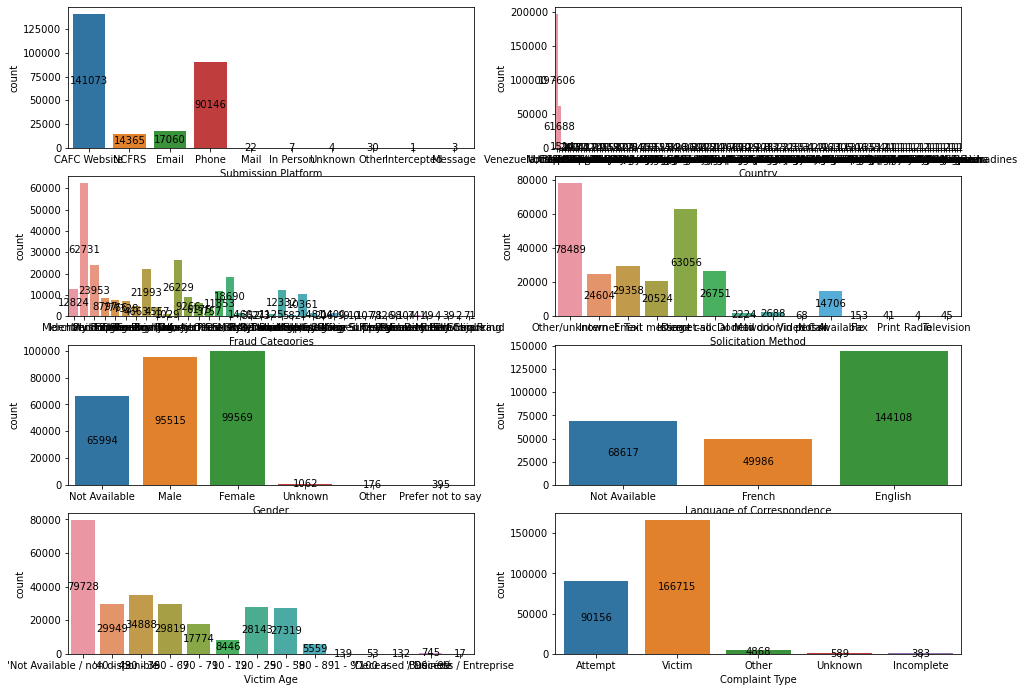

In [7]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(fraud_data.columns[:-2]):
    ax = plt.subplot(5, 2, idx+1)
    sns.countplot(x=fraud_data[col], ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

We will use the information from these graphes to clean the data.

### Data Cleaning
There are no null values, but many entries are labeled as 'Not available,' 'Not specified,' or 'Unknown.' Here's what we've observed after reviewing the columns:

<b>Submission Platform</b> indicates where the complaint was submitted. 'Mail', 'In Person', 'Other', 'Intercepted', 'Unknown' and 'Message' only have few instances, we can merge then under 'Other'.

<b>Country</b> and <b>Fraud Categories</b> can be left as is.

<b>Solicitation Method</b> is crucial for identifying fraud; however, 14706 entries are labeled as 'Not Available' out of 262710 data points. Dropping rows with unavailable data in this column seems acceptable.

<b>Gender</b>, <b>Language of Correspondence</b> and <b>Victim Age</b> have missing values. which shouldn't significantly impact the analysis.

I propose filtering the data to drop rows with more than 3 columns containing missing values.

In [8]:
fraud_data = fraud_data[fraud_data['Solicitation Method'] != 'Not Available']

Let's drop entries where <b>Gender</b>, <b>Language of Correspondence</b> and <b>Victim Age</b> are missing simultaneously. The we can rename some values.

In [9]:
indexes = fraud_data[(fraud_data["Gender"] == "Not Available") & 
                    (fraud_data["Language of Correspondence"] == "Not Available") & 
                    (fraud_data["Victim Age"] == "'Not Available / non disponible")].index

fraud_detection = fraud_data.drop(indexes)
fraud_detection.reset_index(drop=True, inplace=True)
fraud_detection.head(3)

,Submission Platform,Country,Fraud Categories,Solicitation Method,Gender,Language of Correspondence,Victim Age,Complaint Type,Number_Victims,Money_Loss
0,CAFC Website,Canada,Identity Fraud,Other/unknown,Male,French,'40 - 49,Victim,1,$0.00
1,CAFC Website,Canada,Phishing,Email,Male,English,'30 - 39,Victim,1,$0.00
2,CAFC Website,Canada,Merchandise,Other/unknown,Male,Not Available,'60 - 69,Victim,1,$222.73


Let's rename values.

In [10]:
fraud_detection['Submission Platform'].replace(['Mail', 'In Person', 'Unknown', 'Message'], 'Other', 
                                               inplace=True)
fraud_detection['Gender'].replace('Not Available', 'Unknown', inplace=True)
fraud_detection['Language of Correspondence'].replace('Not Available', 'Not specified', inplace=True)
fraud_detection['Victim Age'].replace(["'Not Available / non disponible", 
                                  "'Deceased / Décédé","'Business / Entreprise"],
                                 ["Unknown", "Deceased","Business"], inplace=True)
fraud_detection['Complaint Type'].replace(['Incomplete', 'Unknown'], 'Other', inplace=True)

When we take a look at the country column, some of the countries listed have value counts of 1. Since Canada and United States have the high counts, we can goup the remaining countries under the label 'Other Country'. 'Not Specified' can stay as is.

In [11]:
# This can be uncommented to see all value counts in Country columns
#pd.set_option('display.max_rows', None)
print(fraud_detection['Country'].value_counts())
#pd.reset_option('display.max_rows')

Canada            185815
Not Specified       8512
United States       1227
India                163
United Kingdom        97
                   ...  
Vanuatu                1
Guernsey               1
Mali                   1
Sudan                  1
Barbados               1
Name: Country, Length: 142, dtype: int64


In [12]:
names = []
for index, name in enumerate(fraud_detection['Country'].value_counts().index.tolist()):
    if fraud_detection['Country'].value_counts()[index] < 200:
        names.append(name)
        
fraud_detection['Country'].replace(names, 'Other Country', inplace=True)
print(fraud_detection['Country'].value_counts())

Canada           185815
Not Specified      8512
Other Country      1540
United States      1227
Name: Country, dtype: int64


When we take a look at Submission Platform and Country, they look much better.

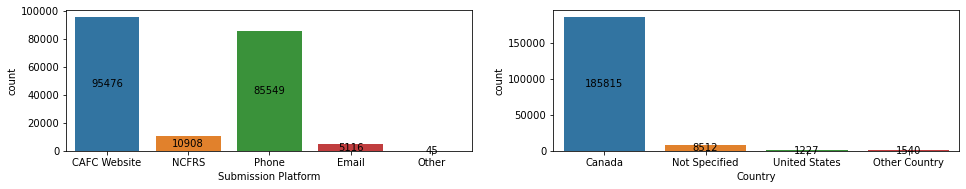

In [13]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(fraud_detection.columns[:2]):
    ax = plt.subplot(5, 2, idx+1)
    sns.countplot(x=fraud_detection[col], ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

Now we deal with the <b>Money_Loss</b> column. Let's set instances where there is no monetary loss to 0 and those with loss of money to 1.

In [14]:
fraud_detection['Money_Loss'] = fraud_detection['Money_Loss'].apply(lambda x: 0 if x=="$0.00" else 1)

In [15]:
fraud_detection.head(3)

,Submission Platform,Country,Fraud Categories,Solicitation Method,Gender,Language of Correspondence,Victim Age,Complaint Type,Number_Victims,Money_Loss
0,CAFC Website,Canada,Identity Fraud,Other/unknown,Male,French,'40 - 49,Victim,1,0
1,CAFC Website,Canada,Phishing,Email,Male,English,'30 - 39,Victim,1,0
2,CAFC Website,Canada,Merchandise,Other/unknown,Male,Not specified,'60 - 69,Victim,1,1


In [16]:
# We can save the data if we want
fraud_detection.to_csv("fraud_reporting_data.csv", index = False)

## 2. Prediction
### Feature Selection
All columns different from the target are feature candidates so fare. But we need to find out how which one has the best corralation with the target column. First we convert the categorical columns into numerical data. I chosed to use the LabelEncoder(). And a heatmap for the correlation.

In [17]:
le = LabelEncoder()

num_fd = fraud_detection.apply(le.fit_transform)
num_fd.head(2)

,Submission Platform,Country,Fraud Categories,Solicitation Method,Gender,Language of Correspondence,Victim Age,Complaint Type,Number_Victims,Money_Loss
0,0,0,13,7,1,1,5,2,1,0
1,0,0,23,2,1,0,4,2,1,0


<AxesSubplot:>

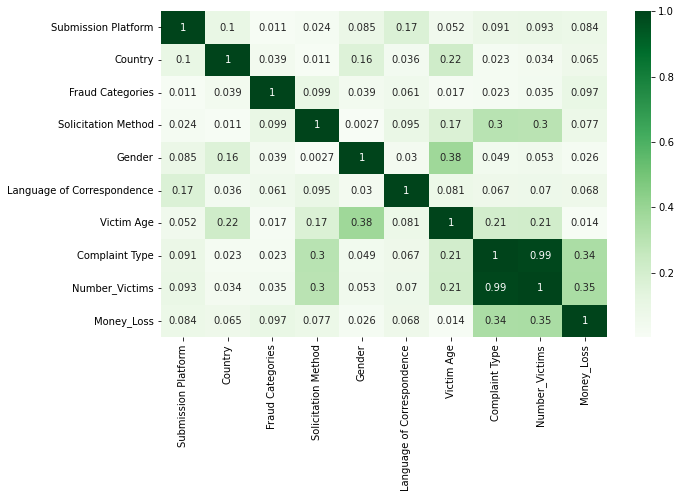

In [18]:
correlations = abs(num_fd.corr())
plt.figure(figsize=(10,6))
sns.heatmap(correlations, annot=True, cmap="Greens")

Values in <b>Complaint Type</b> are closely related to number of victims, hence the 0.99 correlation coefficient. About 91% of values in <b>Complaint Type</b> are equal to values in <b>Number_Victims</b>. So we won't use it as a feature.

In [19]:
print(num_fd[num_fd['Complaint Type'] != num_fd['Number_Victims']].value_counts().count())
print(num_fd.shape)
print(100 - (16563/197094)*100)

16563
(197094, 10)
91.59639562848184


A threshold of 0.2 can be set on the correlation coefficient. We narrow down the features to <b>Solicitation Method</b>, <b>Victim Age</b> and <b>Money_Loss</b>.  

<AxesSubplot:>

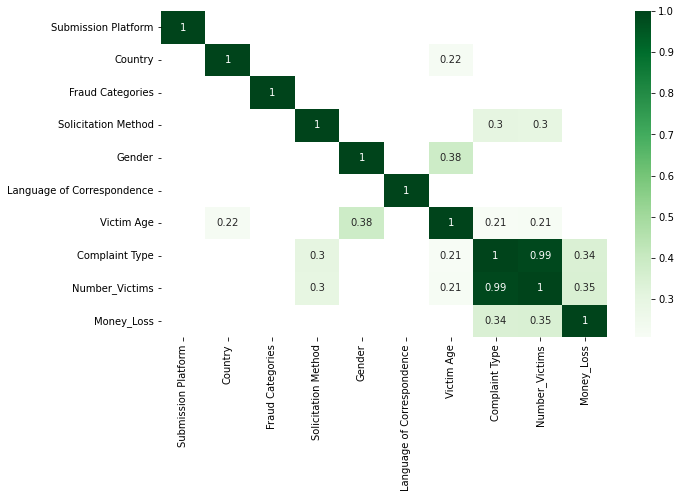

In [20]:
plt.figure(figsize=(10,6))
sns.heatmap(correlations[correlations > 0.2], annot=True, cmap="Greens")

### Building a Classifier
We split the dataset into training and validation set first.

In [21]:
X = num_fd.drop(["Number_Victims"], axis=1)
y = num_fd["Number_Victims"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=500)

features = ["Solicitation Method", "Victim Age", "Money_Loss"]

We normalize (put features on a similar scale) the data before training. This will improve the performance and training stability of the model.

In [22]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [23]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print("Accuracy:", accuracy*100,"%")

Accuracy: 81.42520104518127 %


We have an accuracy of ~ 81%, which is quite good. Let's see which hyperparameters might be optimal for the model.
### Hyperparameter Optimization

In [24]:
# first we prepare the data
X = num_fd.drop(["Number_Victims"], axis=1)
y = num_fd["Number_Victims"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 500)

features = ["Solicitation Method", "Victim Age", "Money_Loss"]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])

Grid search can be used to explore for parameters in a given range. We set n_neighbors to a range of 1 to 20.

In [25]:
# this migth take a while
params = {"n_neighbors": range(1, 10)}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 10)}, scoring='accuracy')

In [26]:
# Results
knn_grid.best_score_*100, knn_grid.best_params_

(83.12478198826699, {'n_neighbors': 8})

The best fit is obtained for n_neighbors = 8
### Model testing

In [27]:
predict = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predict)

print("The model accuracy on test dataset is:", accuracy*100,"%")

The model accuracy on test dataset is: 83.40140541363303 %


Our model can predict fraud victims with an accuracy of 83.8%. It's important to note that we only used three features for this prediction, which may affect the model's accuracy. Further investigation might be necessary for a conclusive decision.